Connected to jax (Python 3.11.9)

In [1]:
pwd

'/home/user/PycharmProjects/SkillLearning/GoToRL/src/RSP/scripts'

In [2]:
cd ../../../

/home/user/PycharmProjects/SkillLearning/GoToRL


/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pwd

'/home/user/PycharmProjects/SkillLearning/GoToRL'

In [4]:
from src.common.context import load_model
from src.RSP.rsp_act_seq import RSP, Decoder
import jax
import jax.numpy as jp

2024-11-30 02:54:00.871588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 02:54:00.893224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 02:54:00.903887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 02:54:01.738034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from src.common.context import load_model, prepare_ckpt
from src.RSP.rsp_act_seq import RSP, Decoder, Encoder, RNG_KEYS
import jax
import jax.numpy as jp

In [6]:
from pathlib import Path
# save_dir = "/home/user/PycharmProjects/SkillLearning/GoToRL/output_dir/rsp_vit_tiny_patch16/kitchen-act/2024-11-29_12-35-27/ckpt"
save_dir = "/home/user/PycharmProjects/SkillLearning/GoToRL/output_dir/rsp_vit_tiny_patch16/kitchen-seq/2024-11-29_21-59-29/ckpt"
save_dir = Path(save_dir)

tmp_ckpt = prepare_ckpt(save_dir, monitor="loss", best_mode="min", keep_n=5)

In [7]:
print(tmp_ckpt.best_step())
variables = load_model(tmp_ckpt, epoch_idx=-1)

40000


In [8]:
from pprint import pp
pprint = lambda x: pp(x, width=120)

params = variables["params"]
pprint(jax.tree.map(jp.shape, params))

{'decoder': {'dec_act_pred': {'bias': (36,), 'kernel': (512, 36)},
             'dec_blocks_0': {'Attention_0': {'Dense_0': {'bias': (1536,), 'kernel': (512, 1536)},
                                              'Dense_1': {'bias': (512,), 'kernel': (512, 512)}},
                              'CrossAttention_0': {'Dense_0': {'bias': (1024,), 'kernel': (512, 1024)},
                                                   'Dense_1': {'bias': (512,), 'kernel': (512, 512)},
                                                   'Dense_2': {'bias': (512,), 'kernel': (512, 512)}},
                              'LayerNorm_0': {'bias': (512,), 'scale': (512,)},
                              'LayerNorm_1': {'bias': (512,), 'scale': (512,)},
                              'LayerNorm_2': {'bias': (512,), 'scale': (512,)},
                              'LayerNorm_3': {'bias': (512,), 'scale': (512,)},
                              'MLP_0': {'Dense_0': {'bias': (2048,), 'kernel': (512, 2048)},
              

In [9]:
from src.RSP.config import RSPConfig
from src.RSP.rsp_act_seq import rsp_vit_tiny_patch16

cfg = RSPConfig.load(save_dir.parent)
rsp = rsp_vit_tiny_patch16(
    img_size=cfg.input_size,
    act_size=cfg.act_size,
    seq_len=cfg.max_distance - 1,
    stoch=cfg.stoch,
    discrete=cfg.discrete,
    mask_rate=cfg.mask_rate,
    noise_scale=cfg.noise_scale,
)

In [10]:
print(variables.keys())
variables.pop("metrics")
variables= {"params": variables.pop("params"), **variables.pop("extra_variables")}

dict_keys(['extra_variables', 'metrics', 'params'])


In [11]:
variables.keys()

dict_keys(['params', 'pos_emb'])

In [12]:
import d4rl
import gym
from src.RSP.evaluation import kitchen_render
import matplotlib.pyplot as plt

env_name = "kitchen-mixed-v0"
env = gym.make(env_name)

/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:48:36
/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/pybullet_envs/env_bases.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/pkg_resources/__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resourc

Reading configurations for Franka
Initializing Franka sim


  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



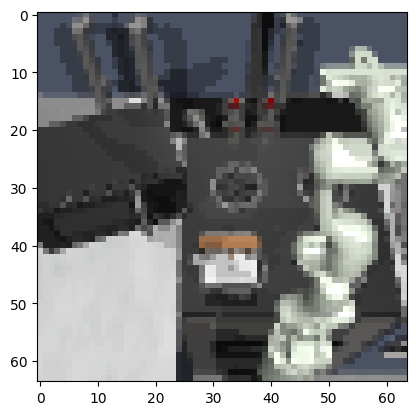

In [13]:
plt.imshow(kitchen_render(env, wh=64))

In [ ]:
from collections import defaultdict
from functools import partial
from src.common.context import make_rngs
from tqdm import tqdm

done = False
step = 0
record = defaultdict(list)

obs = env.reset()
obs_img = kitchen_render(env, wh=64)
rng = jax.random.PRNGKey(0)

pbar = tqdm(total=env.spec.max_episode_steps)
policy_fn = jax.jit(partial(rsp.apply, variables, method="predict"))

while not done:
    rng, rngs = make_rngs(rng, RNG_KEYS)
    # imgs = jax.jit(partial(rsp.apply, variables, modal="img", method="predict"))(obs_img[None], rngs=rngs)
    # actions = jax.jit(partial(rsp.apply, variables, modal="act", method="predict"))(obs_img[None], rngs=rngs)
    # imgs, actions = jax.jit(partial(rsp.apply, variables, method="predict"))(obs_img[None], rngs=rngs)
    actions_records = jp.zeros((cfg.max_distance, cfg.act_size))
    imgs, actions = policy_fn(obs_img[None], actions_records, rngs=rngs)
    actions_records.at[step] = actions[step]
    
    record["src_img"].append(obs_img)
    record["tgt_img"].append(imgs)
    for action in actions[0, :cfg.min_distance]:
        obs, rew, done, info = env.step(action)
        record["actions"].append(action)
        record["rewards"].append(rew)
        record["dones"].append(done)

        if step % 3 == 0:
            record["frames"].append(kitchen_render(env, wh=64).transpose(2, 0, 1))
        
        step += 1
        pbar.update(1)
        if done:
            break
        
    obs_img = kitchen_render(env, wh=64)

100%|██████████| 280/280 [01:23<00:00,  4.48it/s]

In [15]:
record.keys()

dict_keys(['src_img', 'tgt_img', 'actions', 'rewards', 'dones', 'frames'])

In [16]:
import numpy as np

record = {k: np.stack(v) for k, v in record.items()}
jax.tree.map(lambda x: x.shape, record)

{'actions': (280, 9),
 'dones': (280,),
 'frames': (94, 3, 64, 64),
 'rewards': (280,),
 'src_img': (35, 64, 64, 3),
 'tgt_img': (35, 1, 64, 64, 3)}

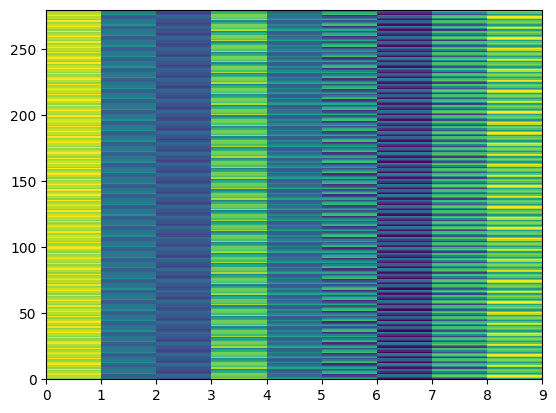

In [17]:
plt.pcolormesh(record["actions"])

In [22]:
from moviepy.editor import ImageSequenceClip
from src.RSP.datasets import img_inverse_normalize

src_imgs = record["src_img"]
tgt_imgs = img_inverse_normalize(record["tgt_img"].squeeze())
print(src_imgs.shape, tgt_imgs.shape)

imgs = np.concatenate([src_imgs, tgt_imgs], axis=2)
clip = ImageSequenceClip(list(imgs), fps=10)
clip.write_gif("kitchen_seq.gif", fps=10)

100%|██████████| 280/280 [06:53<00:00,  4.48it/s]

(35, 64, 64, 3) (35, 64, 64, 3)
MoviePy - Building file kitchen_seq.gif with imageio.


array([[[[ 75,  82,  99],
         [ 75,  82,  99],
         [ 75,  82,  99],
         ...,
         [ 75,  82, 100],
         [ 75,  82, 100],
         [ 75,  82, 100]],

        [[ 75,  82,  99],
         [ 75,  82,  99],
         [ 75,  82,  99],
         ...,
         [ 75,  82, 100],
         [ 75,  82, 100],
         [ 75,  82, 100]],

        [[ 75,  82,  99],
         [ 75,  82,  99],
         [ 75,  82,  99],
         ...,
         [ 75,  82, 100],
         [ 75,  82, 100],
         [ 75,  82, 100]],

        ...,

        [[214, 214, 214],
         [208, 209, 209],
         [209, 209, 209],
         ...,
         [ 75,  82,  97],
         [ 75,  82,  97],
         [ 75,  82,  97]],

        [[213, 213, 213],
         [209, 209, 209],
         [209, 209, 209],
         ...,
         [ 92,  97, 108],
         [ 92,  97, 109],
         [ 92,  98, 109]],

        [[209, 211, 210],
         [208, 209, 209],
         [209, 209, 209],
         ...,
         [141, 141, 142],
        

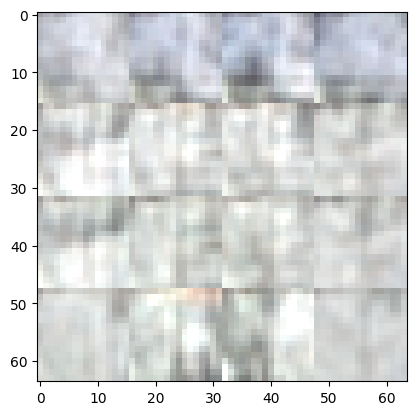

In [25]:
plt.imshow(img_inverse_normalize(record["tgt_img"][0].squeeze()))